
# {{ mandatory }} PCA for shape generation
In this mandatory exercise you will use PCA to generate face shapes. The goal is to have you explore the relation between points in latent space and data space (which in this instance is faces). 

```{warning}
Please read the introduction to PCA in exercise 10.1 carefully and solve the exercises before starting on this assignment. The transformations between data space and latent space are needed for this assigment. However, no questions and task from this asssigment will be about the exercise. However, you are, as always, welcome to ask about the exercise implementation at the dedicated times. 
```


```{note}
{{ answer }} markers indicate where you should write your answers to each question. All enumerated tasks (tasks with preceeding letters) has an answer field if it requires answers in prose.
```

The exercise is subdivided into the following two sections:

- {{ mandatory-task }} {ref}`pca:gen` (questions A-J)
- {{ mandatory-task }} {ref}`pca:reflect` (questions A-B

## Hand-in
You have to write your solutions and answers in this Jupyter Notebook. The hand-in have to be a zip file of the entire exercise folder for this week (including the data!). The assignment is handed in on the LearnIT course page under `assigment 3`. **Additionally**, make sure to only use python packages utilized throughout the course, and not any new libraries that require installation. 

In [6]:
## Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2 as cv

import os
from glob import glob

from utils import *
from utils import plot_many_faces

## PCA implementation
Copy your PCA implementation into the following cell:


In [7]:
# Copy your PCA implementation to here.

## {{ mandatory-task }} Using PCA for shape generation

PCA can be used as a generative process, where
new samples in data space can be generated by transforming a point in latent space. Thus, generating a new face $x$ can be done by using $x = \Phi_{:k} b + \mu$, where $\Phi$ is the matrix of eigenvectors, $b$ is a vector in latent space, and $\mu\in\mathbb{R}^{M}$ is the means of the data space features.

We start at $b=\mathbf{0}$. The variance in each direction can be used to define reasonable boundary values for each principal component. Since $b$ is in latent space, we need to calculate the variance of our transformed data. For each feature space dimension, a range of $[-3\sigma_i, 3\sigma_i]$ is used where $\sigma_i = \sqrt{Var(b_i)}$. Assuming the faces are normally distributed, $\pm 3\sigma$ covers $99.7\%$ of all points. This is shown in {numref}`fig:normal`. 

```{figure} ./img/normal.png
---
name: fig:normal
width: 400px
---
Illustration of a normal distribution. The shaded regions indicate the
area of the distribution covered by 1, 2, 3, and 4, standard deviations
($\sigma$) respectively.
```



A): {{ task-code }} **Get principal components:** Repeat what you did in the _Introduction to PCA_ exercise and compute the principal components $\Phi$ for the face dataset. Verify that your implementation is working correctly by using the `plot_many_faces` function (imported from `utils.py`) to plot $5$ face shapes before and after transforming to and back from latent space.


120


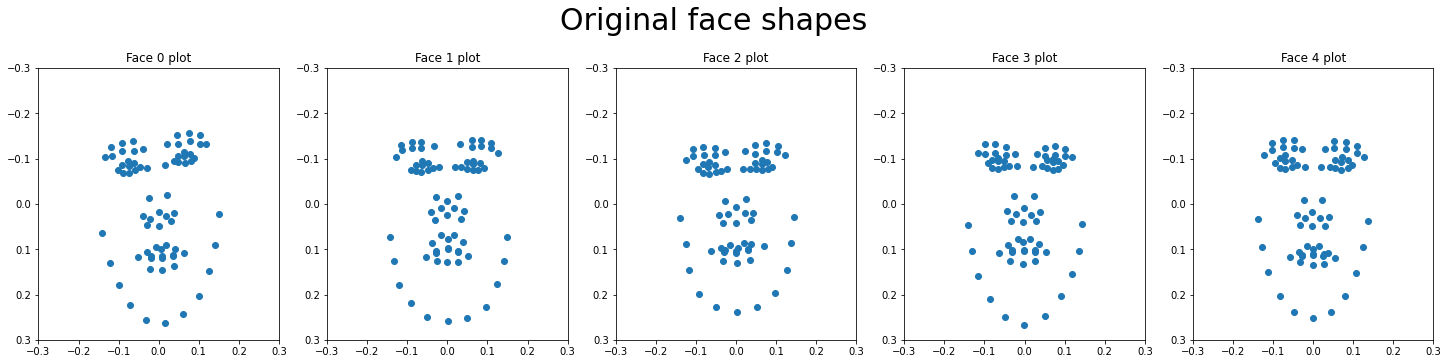

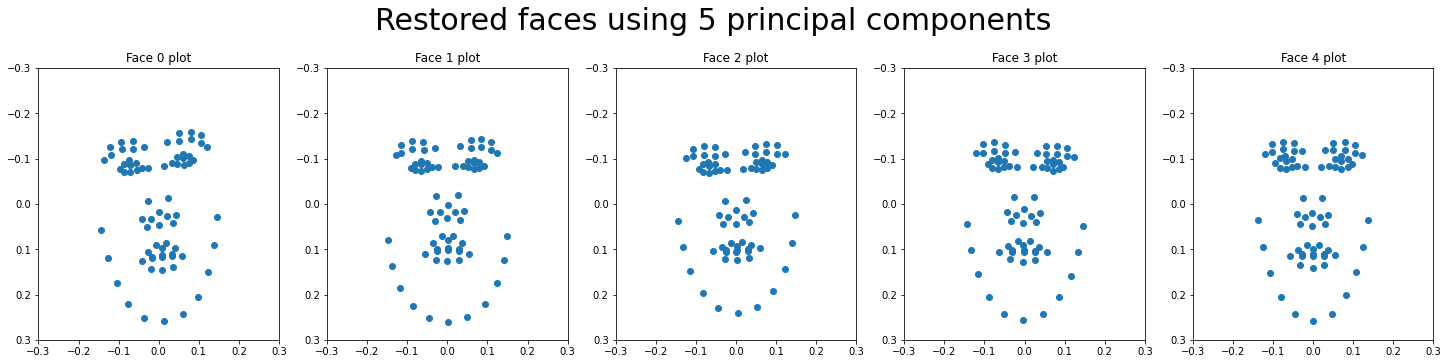

In [15]:

# Implementation for A)
# Get the principal components for the dataset and transform the faces to feature space.
# Uncomment below when you have copied your implementation

path = './db/'
shapes, images = face_shape_data(path)
#########################################################################
# comp, val, mu = get_principle_components(shapes)

# n_components = 5

# used = comp[:, :n_components]

# plot_many_faces(shapes[:5],"Original face shapes")
# transformed = transform(shapes[:5], used, mu)
# restored = inverse_transform(transformed, used, mu)
# plot_many_faces(restored,"Restored faces using 5 principal components")


B): 
- {{ task-code }} **Generate vectors:** Create a zero vector with $5$ dimensions, i.e. $b = [0, 0, \dots, 0]$. This will be your starting point. 
- {{ task-code }} **Shape generation:** Use $x = \Phi_{:5} b + \mu$ to generate a vector in real space from the zero vector (you may reuse the implementation from the exercise). Use the provided utility function `plot_face` to visualise the generated face as a plot.


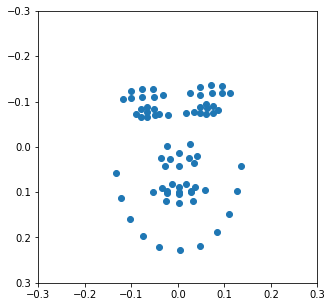

In [10]:
# Implementation for B)
# std = transformed.std(axis=1)

C): {{ task-written }} **Base face:** Describe what the face generated using the zero vector represents and why this is the case. You should be able to deduce why from your knowledge about PCA.

**{{ answer }} Answer**

...

+++

D): 
- {{ task-code }} **Varying components:** Start experimenting with changing the vector component values and watch the effect it has on the output.
- {{ task-code }} **Component controls:** Interpolate 5 values in the range $[-3\sigma_1, 3\sigma_1]$ for the first component $y_1$, generate the faces and visualise them.


[-0.10025988 -0.12789965 -0.10380763 -0.08590734 -0.03990501]
[-0.05012994 -0.06394983 -0.05190381 -0.04295367 -0.01995251]
[0. 0. 0. 0. 0.]
[0.05012994 0.06394983 0.05190381 0.04295367 0.01995251]
[0.10025988 0.12789965 0.10380763 0.08590734 0.03990501]


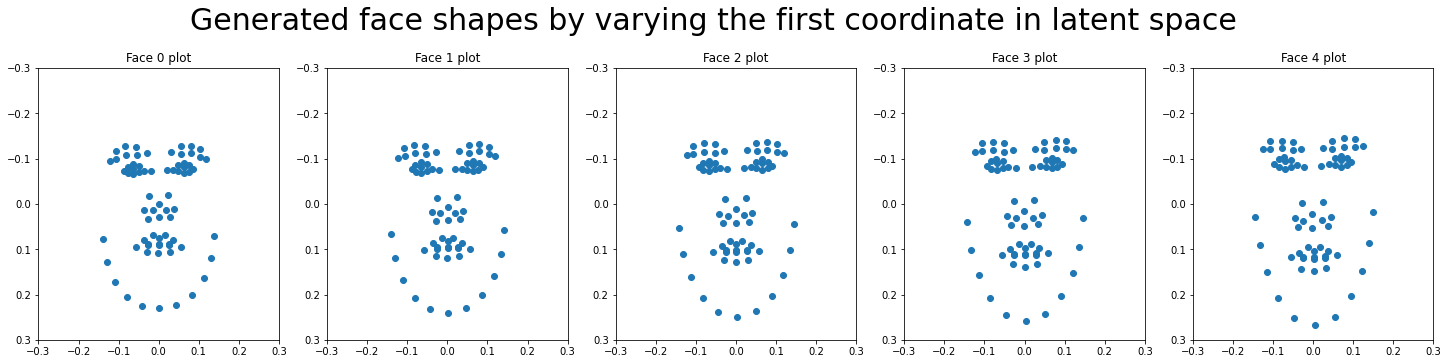

In [11]:
# Implementation for C)
# z = np.zeros(n_components)

# # Write your solution here

E): {{ task-writing }} **More components:** Do the same for each of the next four components, i.e. $b_2$-$b_5$. Write down what each component changes in the image (for example, the first component may change the height of the face). 

**{{ answer }} Answer**

...

F): {{ task-writing }} **Extreme values:** What happens if you select values outside the suggested range. Explain why this happens.

**{{ answer }} Answer**

...

+++

G): {{ task-code }} **Transform data:** Use $\Phi_{:k}^\top$ to transform the database faces into feature-space (using $x' = \Phi_{:k}^\top(x-\mu)$).

In [12]:
# Implementation for G)


H): {{ task-code }} Plot the two first components in latent space using a scatterplot.
- {{ task-writing }} What does this plot tell you about the distribution of faces?
- {{ task-writing }} Experiment with showing different components. Describe how the plot changes.

**{{ answer }} Answer**

...


In [13]:

# Implementation for H)


I): {{ task-code }} **Shape Interpolation:** Create two faces by selecting two points in latent space, try to select two points far from each other in latent space, but not creating unrealstic faces. You can choose the number of components non-zero values. Now you should `np.linspace` to interpolate between the two points. Use `num` to control the number of output values. Plot the resulting faces. Below is an example of how to interpolate two vectors.


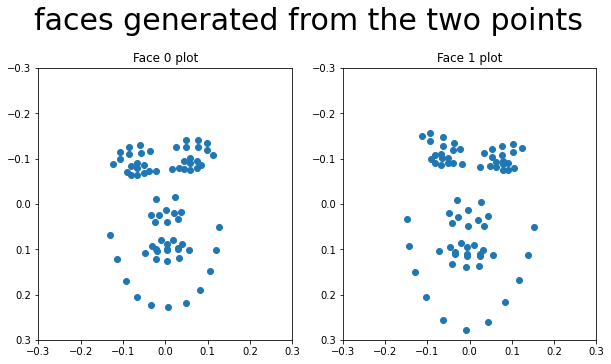

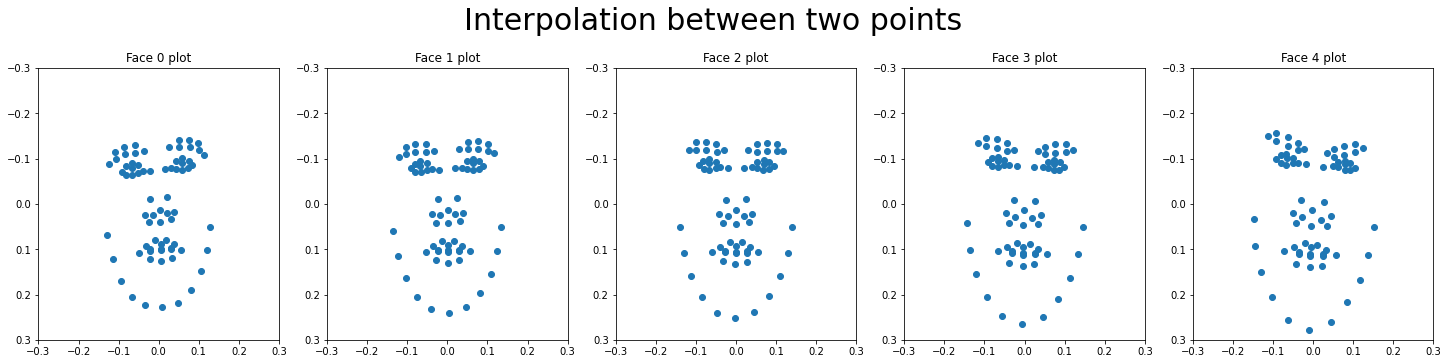

In [14]:
## linspace example 
d = np.linspace(np.array([1, 2]), np.array([3, 5]), num=5)
plt.scatter(d[:, 0], d[:, 1])

## write your own implementation here

J): {{ task-writing }} **Behaviour:** Assume a set of points on a line in latent space. Argue for why the same set of points, when mapped to real space using $x = \Phi_{:k}b + \mu$ also lie on a line.

**{{ answer }} Answer**

...

+++

(pca:reflect)=
## {{ mandatory-task }} Reflection
Describe and reflect on the results gathered from various parts of the exercises for week 10 (including the non-mandatory ones). Answer the following questions (and back up your arguments with results or theory)

A): {{ task-writing }} What did you think of the results from the generative model? Explain why so few principal components are needed to reproduce the samples quite accurately.
  
**{{ answer }} Answer**

...

 
B): {{ task-writing }} How many components do you need to have $50\%$, $60\%$, $80\%$, $95\%$ of the total variation?

**{{ answer }} Answer**

...
